# Dependency parsing of the answers

In [41]:
import stanza
import pandas as pd
import matplotlib.pyplot as plt
import re

In [83]:
stanza.download('sv', processors='tokenize,pos,lemma,depparse')
nlp = stanza.Pipeline(lang='sv', processors='tokenize,pos,lemma,depparse')

# Example usage
doc = nlp('Du behöver ta med ditt pass.')
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in doc.sentences for word in sent.words], sep='\n')

2022-01-31 11:13:00 INFO: Downloading these customized packages for language: sv (Swedish)...
| Processor | Package   |
-------------------------
| tokenize  | talbanken |
| pos       | talbanken |
| lemma     | talbanken |
| depparse  | talbanken |
| pretrain  | talbanken |

2022-01-31 11:13:00 INFO: File exists: /Users/filippakarrfelt/stanza_resources/sv/tokenize/talbanken.pt.
2022-01-31 11:13:00 INFO: File exists: /Users/filippakarrfelt/stanza_resources/sv/pos/talbanken.pt.
2022-01-31 11:13:01 INFO: File exists: /Users/filippakarrfelt/stanza_resources/sv/lemma/talbanken.pt.
2022-01-31 11:13:01 INFO: File exists: /Users/filippakarrfelt/stanza_resources/sv/depparse/talbanken.pt.
2022-01-31 11:13:01 INFO: File exists: /Users/filippakarrfelt/stanza_resources/sv/pretrain/talbanken.pt.
2022-01-31 11:13:01 INFO: Finished downloading models and saved to /Users/filippakarrfelt/stanza_resources.
2022-01-31 11:13:01 INFO: Loading these models for language: sv (Swedish):
| Processor | Package  

id: 1	word: Du	head id: 3	head: ta	deprel: nsubj
id: 2	word: behöver	head id: 3	head: ta	deprel: aux
id: 3	word: ta	head id: 0	head: root	deprel: root
id: 4	word: med	head id: 3	head: ta	deprel: compound:prt
id: 5	word: ditt	head id: 6	head: pass	deprel: nmod:poss
id: 6	word: pass	head id: 3	head: ta	deprel: obj
id: 7	word: .	head id: 3	head: ta	deprel: punct


In [84]:
for sentence in doc.sentences:
    for word in sentence.words:
        print(word.text, word.lemma, word.pos, word.deprel)

Du du PRON nsubj
behöver behöva AUX aux
ta ta VERB root
med med ADP compound:prt
ditt du PRON nmod:poss
pass pass NOUN obj
. . PUNCT punct


In [85]:
# Load the dataframes consisting of the data
df_train = pd.read_pickle("./data_frames/df_train.pkl")
df_test = pd.read_pickle("./data_frames/df_test.pkl")
df_train.head()

,choices,context,question,correct_answer,correct_answer_loc,answer_reformulation,answer_location,sent_with_ans,answer_locations_text,paragraph_len,loc_frac
0,"[{'end': 224, 'extra': None, 'start': 175, 'te...",Visum för affärs- och konferensbesök\r\nOm du ...,Vad är ett visum?,ett tillstånd för att resa in och vara i ett land,175,False,2,Visum är ett tillstånd för att resa in och var...,[2],27,0.074074
1,"[{'end': 707, 'extra': None, 'start': 681, 'te...",Eget företag\r\nEfter beslut\r\nBeslutet skick...,Vad ska du ta med när du hämtar ditt beslut?,ditt pass,156,False,3,När du ska hämta ditt beslut ska du ta med dit...,"[3, 4]",20,0.150000
2,"[{'end': 1165, 'extra': None, 'start': 1154, '...",Utbytesdoktorander\r\nIntervju\r\nDu kommer at...,Hur länge gäller ett uppehållstillstånd för be...,ett år,1619,False,21,Ett uppehållstillstånd för besök gäller som lä...,[21],29,0.724138
3,"[{'end': 598, 'extra': None, 'start': 589, 'te...",Eget företag\r\nNär vi har tagit emot din ansö...,Vad är ett uppehållstillståndskort?,ett bevis,589,False,7,Kortet är ett bevis på att du har tillstånd at...,[7],30,0.233333
4,"[{'end': 1932, 'extra': None, 'start': 1924, '...",Flytta tillbaka till Sverige\r\nSå ansöker du\...,Vad är ett uppehållstillståndskort?,ett bevis,673,False,9,Kortet är ett bevis på att du har tillstånd at...,[9],23,0.391304


In [89]:
# Find the word type of the root in every answer in the dataset
def parse_doc(doc):
    dict = { 'words': [], 'pos': [], 'deprel': [], 'root': None, 'root_word': None, 'root_pos': None,}
    for sentence in doc.sentences:
        for word in sentence.words:
            # print(word.text, word.lemma, word.pos, word.deprel)
            dict['words'].append(word.lemma)
            dict['pos'].append(word.pos)
            dict['deprel'].append(word.deprel)
            if word.deprel == 'root':
                dict['root'] = word.lemma
                dict['root_word'] = word.text
                dict['root_pos'] = word.pos
    return dict

def add_to_dependency_dict(answer, sent_with_ans, question, ans_doc, sent_doc, q_doc):
    ans_dict = parse_doc(ans_doc)
    sent_dict = parse_doc(sent_doc)
    q_dict = parse_doc(q_doc)
    dict_item = { 'answer': answer, 'answer_words': [], 'answer_pos': [], 'answer_deprel': [], 'answer_root': None, 'answer_root_pos': None,
            'sent_with_ans': sent_with_ans, 'sent_words': [], 'sent_pos': [], 'sent_deprel': [], 'sent_root': None, 'sent_root_pos': None,
            'question': question, 'q_words': [], 'q_pos': [], 'q_deprel': [], 'q_root': None, 'q_root_pos': None }
    pre_scripts = [('answer_', ans_dict), ('sent_', sent_dict), ('q_', q_dict)]
    for pre in pre_scripts:
        dict_item[pre[0]+'words'] = pre[1]['words']
        dict_item[pre[0]+'pos'] = pre[1]['pos']
        dict_item[pre[0]+'deprel'] = pre[1]['deprel']
        dict_item[pre[0]+'root'] = pre[1]['root']
        dict_item[pre[0]+'root_word'] = pre[1]['root_word']
        dict_item[pre[0]+'root_pos'] = pre[1]['root_pos']
    return dict_item

def dependency_parsing(df):
    dependency_dict = []
    for index, row in df.iterrows():
        answer = row['correct_answer'].lower()
        sent_with_ans = row['sent_with_ans'].lower()
        question = row['question'].lower()
        answer = re.sub('[^\sa-zåäöA-ZÅÄÖ1-9]', '', answer)
        sent_with_ans = re.sub('[^\sa-zåäöA-ZÅÄÖ1-9]', '', sent_with_ans)
        question = re.sub('[^\sa-zåäöA-ZÅÄÖ1-9]', '', question)
        ans_doc = nlp(answer)
        sent_doc = nlp(sent_with_ans)
        q_doc = nlp(question)
        dependency_dict.append(add_to_dependency_dict(answer, sent_with_ans, question, ans_doc, sent_doc, q_doc))
    
    return dependency_dict


In [90]:
# get the word class statistics for the root
def get_word_class_count(data, type):
    stats = {}
    for ans in data:
        word_pos = ans[type + '_root_pos']
        # can be none!
        if word_pos == None:
            print('word has None pos tag: ', ans[type + '_root_word'])
            if 'UNK' not in stats:
                stats['UNK'] = 1
            else:
                stats['UNK'] += 1
        elif word_pos not in stats:
            stats[word_pos] = 1
        else:
            stats[word_pos] += 1
    return stats

In [91]:
# print stats
def print_wordcount_stats(stats, title):
    print('stats: ', stats)
    plt.bar(stats.keys(), stats.values(), color='g')
    plt.title(title)
    plt.show()


In [92]:
dict = dependency_parsing(df_train)
# Save as dataframe
dp_dict_train = pd.DataFrame(dict)
# Save dataframe to file
dp_dict_train.to_pickle("./data_frames/dependency_parsing/df_dp_train.pkl")

stats:  {'NOUN': 507, 'VERB': 346, 'NUM': 63, 'ADJ': 25, 'PRON': 7, 'ADV': 2, 'PROPN': 11, 'ADP': 1}


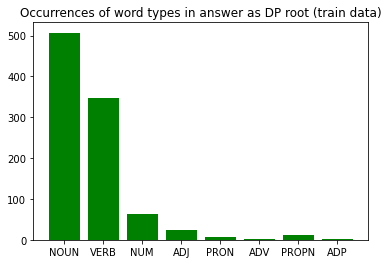

stats:  {'NOUN': 131, 'VERB': 750, 'NUM': 2, 'AUX': 18, 'ADJ': 58, 'PRON': 3}


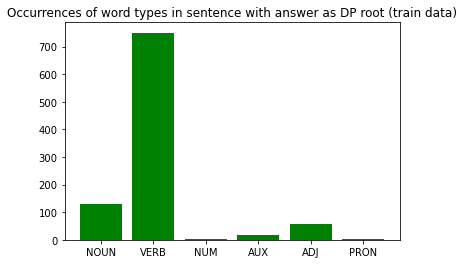

stats:  {'PRON': 73, 'VERB': 770, 'NOUN': 77, 'ADJ': 34, 'ADV': 1, 'AUX': 6, 'NUM': 1}


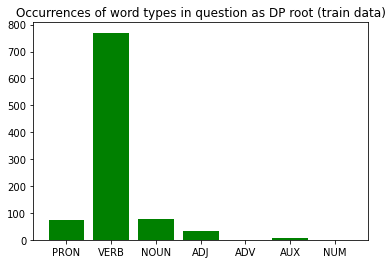

In [93]:
# PLOT STATISTICS

# ans stats
ans_stats = get_word_class_count(dict, 'answer')
title_ans = 'Occurrences of word types in answer as DP root (train data)'
print_wordcount_stats(ans_stats, title_ans)

# ans sent stats
sent_stats = get_word_class_count(dict, 'sent')
title_ans = 'Occurrences of word types in sentence with answer as DP root (train data)'
print_wordcount_stats(sent_stats, title_ans)

# question stats
q_stats = get_word_class_count(dict, 'q')
title_ans = 'Occurrences of word types in question as DP root (train data)'
print_wordcount_stats(q_stats, title_ans)


In [94]:
test_dict = dependency_parsing(df_test)
# create dataframe
dp_dict_test = pd.DataFrame(test_dict)
# Save dataframe to file
dp_dict_test.to_pickle("./data_frames/dependency_parsing/df_dp_test.pkl")

stats:  {'VERB': 33, 'NOUN': 60, 'NUM': 4, 'ADJ': 3, 'PRON': 1, 'AUX': 1}


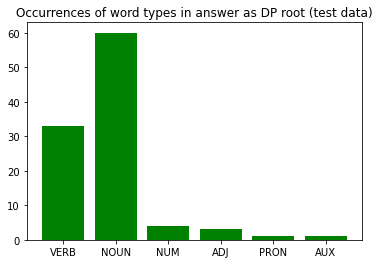

stats:  {'VERB': 71, 'NOUN': 21, 'ADJ': 9, 'NUM': 1}


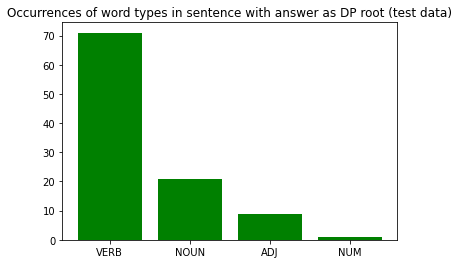

stats:  {'VERB': 79, 'PRON': 7, 'NOUN': 11, 'ADJ': 5}


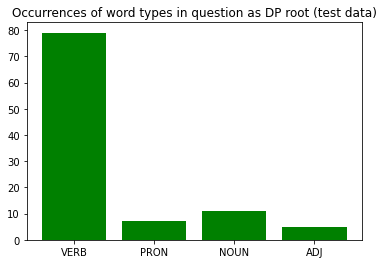

In [95]:
# PRINT STATS

# ans stats
test_ans_stats = get_word_class_count(test_dict, 'answer')
title_ans = 'Occurrences of word types in answer as DP root (test data)'
print_wordcount_stats(test_ans_stats, title_ans)

# sent ans stats
test_sent_stats = get_word_class_count(test_dict, 'sent')
title_ans = 'Occurrences of word types in sentence with answer as DP root (test data)'
print_wordcount_stats(test_sent_stats, title_ans)

# question stats
test_q_stats = get_word_class_count(test_dict, 'q')
title_ans = 'Occurrences of word types in question as DP root (test data)'
print_wordcount_stats(test_q_stats, title_ans)